# Descriptive statistics

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

First, setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr
setup_spreadr('spreadr_exp_1')

Then import all we need for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.metrics import edit_distance
import numpy as np
from pandas import DataFrame
import seaborn as sb

from gists.models import Sentence, Profile, JOB_TYPE_CHOICES

from utils import memoized

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



And equip our models with useful tools: head of a sentence, easy narrowing of a queryset to a bucket

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

## 2 Despamming

First equip our models with some distances and content extraction tools

In [5]:
from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

/home/sl/Code/Research/interpretation-experiment/analysis/linguistics.py:157: UserWarning: 'unordered_content' distance is always normalized, so we're ignoring normalized=False
  warn("'unordered_content' distance is always normalized, so "

  warn("'unordered_content' distance is always normalized, so "



Then compute spam rate

In [6]:
spam_rate = 1 - (Sentence.objects.ham.count() / Sentence.objects.count())
print('Spam represents {:.1f}% of the sentences'.format(spam_rate * 100))

Spam represents 22.4% of the sentences


In [7]:
dropped_rate = 1 - (Sentence.objects.kept.count() / Sentence.objects.count())
print('Spam+rogues represents {:.1f}% of the sentences'.format(dropped_rate * 100))

Spam+rogues represents 25.9% of the sentences


## 3 Interaction of profile variables

Compute the variables

In [8]:
profiles = Profile.objects.all()
raw_rates = []
ordered_content_rates = []
word_span_scores = []
ages = []
genders = []
job_types = []
job_type_map = dict(JOB_TYPE_CHOICES)
print('Computing variables on {} profiles...'.format(len(profiles)), end='')
for i, profile in enumerate(profiles):
    try:
        print(' {}'.format(i + 1), end='')
        raw_rates.append(profile.transformation_rate('raw'))
        ordered_content_rates.append(profile.transformation_rate('ordered_content'))
        word_span_scores.append(profile.word_span.score)
        ages.append(profile.questionnaire.age)
        genders.append(profile.questionnaire.gender)
        job_types.append(job_type_map[profile.questionnaire.job_type])
    except ValueError:
        # Profile has no reformulations
        pass

profiles_interactions = DataFrame({
        'raw TR': raw_rates,
        'ordered content TR': ordered_content_rates,
        'word span score': word_span_scores,
        'age': ages,
        'gender': genders,
        'job type': job_types
    })

Computing variables on 66 profiles... 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66

And plot them, first with gender as color (**not much to say to these graphs**):

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



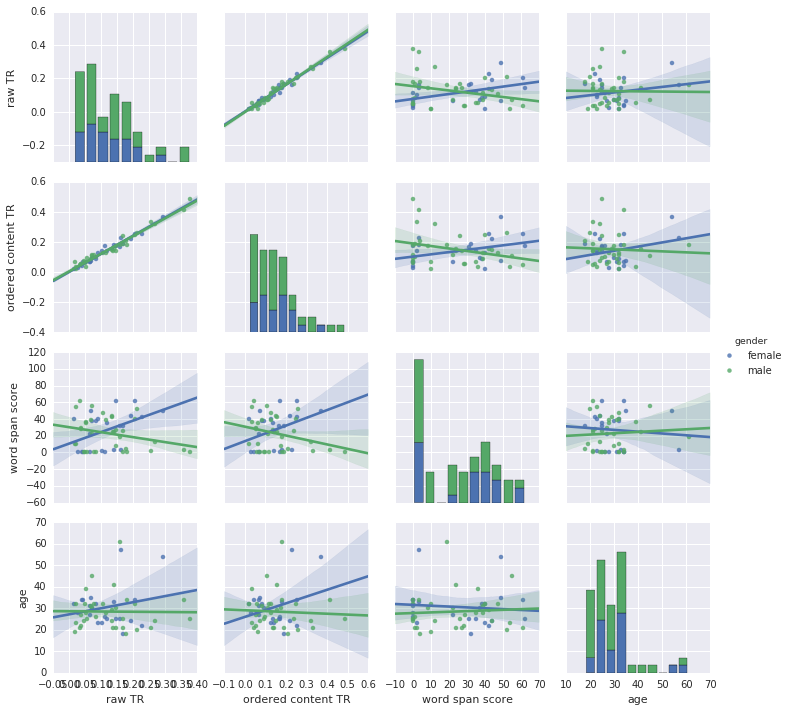

In [9]:
sb.pairplot(profiles_interactions, hue='gender',
            vars=['raw TR',
                  'ordered content TR',
                  'word span score',
                  'age'],
            kind='reg');

Then with job type as color (**not much to say to this either**):

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

  warnings.warn(self.msg_depr % (key, alt_key))



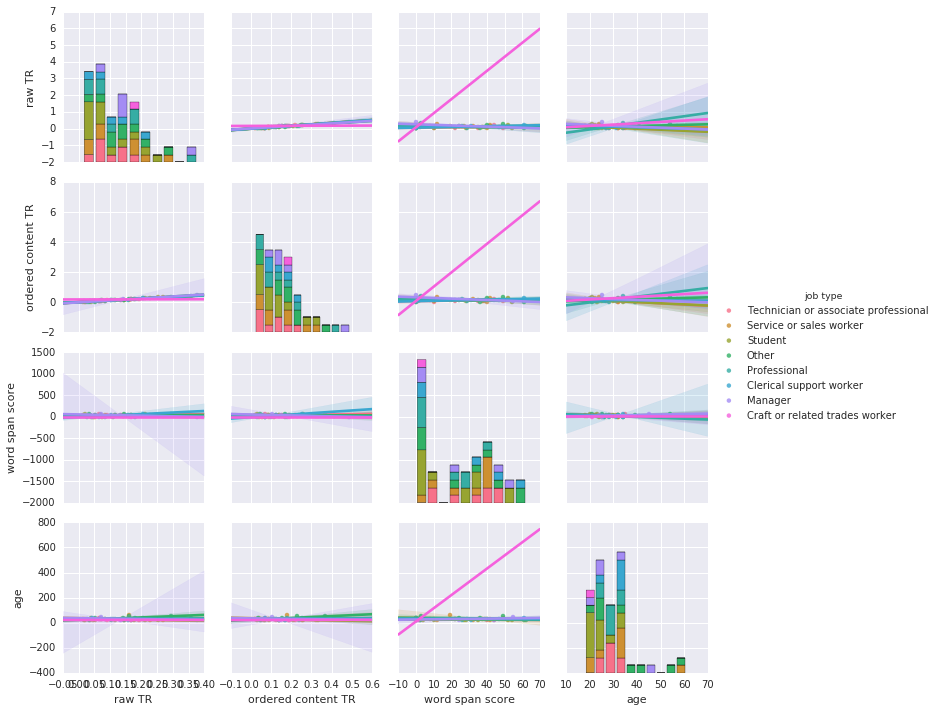

In [10]:
sb.pairplot(profiles_interactions, hue='job type',
            vars=['raw TR',
                  'ordered content TR',
                  'word span score',
                  'age'],
            kind='reg');

Finally, a boxplot of the interaction between gender, job type, and transformation rate (**again, not much to say to this**):

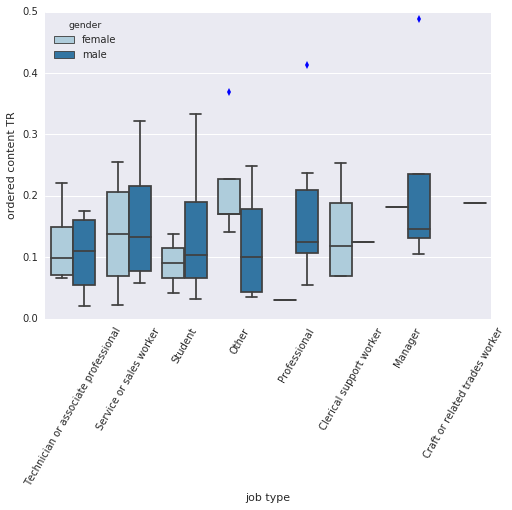

In [11]:
ax = sb.boxplot(data=profiles_interactions, x='job type', y='ordered content TR',
                hue='gender', palette='Paired')
ax.set_xticklabels([t.get_text() for t in ax.get_xticklabels()], rotation=60);

## 4 Reading time check

Have a look at the distribution of reading times to see if it's very varied or not. If it is, the data is not really trustworthy.

In [12]:
read_proportions_spam = []
read_proportions = []

for profile in profiles:
    
    profile_sentences = profile.sentences.filter(parent__isnull=False).all()
    if len(profile_sentences) == 0:
        # Profile has no reformulations
        continue
    
    read_proportions_spam.extend([sentence.read_time_proportion
                                  for sentence in profile_sentences])
    read_proportions.extend([sentence.read_time_proportion
                             for sentence in profile_sentences
                             if not sentence.spam])

read_proportions_spam = np.array(read_proportions_spam)
read_proportions = np.array(read_proportions)

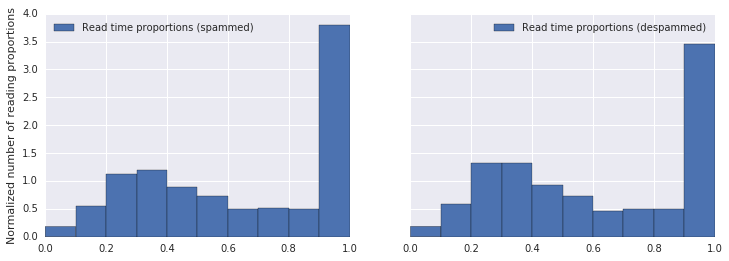

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
axes[0].hist(read_proportions_spam, normed=True, label='Read time proportions (spammed)')
axes[0].legend(loc='best')
axes[1].hist(read_proportions, normed=True, label='Read time proportions (despammed)')
axes[1].legend(loc='best')
axes[0].set_ylabel('Normalized number of reading proportions');

So in both cases (although worse in despammed case):
* about a third of the sentences were produced after using all the reading time,
* a third to a half are produced after using less than half the reading time

Not good, which confirms we must fix this in the next iteration.